# Slightly modified version of Miles' code for the initial crop of our image + 

In [426]:
#The following code snip-it reads any file from the internet and saves it to your local directory.
from urllib.request import urlopen, urlretrieve
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
from skimage import exposure #histogram equalization
import colorsys #To convert to rbg to hsv color space
import matplotlib.colors as colors
import os #For getting list of files
from scipy import ndimage #For performing erosion and dilation

#Get list of photo names
fileNames = ['IMG_8277.jpg','IMG_8280.jpg','IMG_8333.jpg','IMG_8338.jpg','IMG_8342.jpg','IMG_8343.jpg','IMG_8312.jpg','IMG_8284.jpg','IMG_8349.jpg']

#Define thresholds for isolating tray in photos
hmin = -0.01
hmax = 1.01
smin = -0.01
smax = 0.05
vmin = -0.01
vmax = 1.01

#Function for calculating run lengths in a binary array
#function is from: https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

conversion_dict = {}        

#Loop over photos and crop them
for fileName in fileNames:
    #Load picture
    im = imread(fileName)
    
    #Histogram equalization
    im2 = exposure.equalize_hist(im)
    
    #convert from rgb to hsv color space, pull out matrices
    hsv = colors.rgb_to_hsv(im2)
    h = hsv[:,:,0]; #hue matrix
    s = hsv[:,:,1]; #saturation matrix
    v = hsv[:,:,2]; #value matrix (i.e. brightness)
    
    #Convert to binary image based on thresholds
    # trick because the color space wraps
    if hmin > hmax:
        b_img = (h > hmin) | (h < hmax)
    else:
        b_img = (h > hmin) & (h < hmax);
    b_img = (b_img & 
        (s > smin) & (s < smax) & 
        (v > vmin) & (v < vmax));
    
    #Clean up binary image with erosion and dilation
    b4 = skimage.morphology.remove_small_holes(b_img,area_threshold=50000) # removing holes
    b5 = skimage.morphology.remove_small_holes(b4,area_threshold=10000) # removing holes again
    b6 = skimage.morphology.remove_small_holes(b5,area_threshold=10000) # removing even more holes
    b8 = remove_small_objects(b6,min_size=50000) #removing any chaff 
    
    #Label objects in binary image
    lab, num_features = ndimage.measurements.label(b8)
    
    #Sum togther rows and columns of binary array to determine which pixels represent the tray (labeled as object 1) 
    a1 = np.sum(lab==1,axis=1)
    a0 = np.sum(lab==1,axis=0)
    
    #Convert binary arrays to logical arrays. Now just need to find longest run of False elements in each array
    al0 = a0 > min(a0)
    al1 = a1 > min(a1)
    
    #Calculate run lengths
    runLengths0 = rle(al0)
    runLengths1 = rle(al1)
    
    #Focus on columns
    ##Find index of where longest run begins
    runs0 = runLengths0[0]
    positions0 =  runLengths0[1]
    maxRun0 = max(runs0)
    result = np.where(runs0 == maxRun0)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startCol = positions0[index].tolist()[0][0] - 120
    endCol = startCol + maxRun0 + 240
    
    #Focus on rows
    ##Find index of where longest run begins
    runs1 = runLengths1[0]
    positions1 =  runLengths1[1]
    maxRun1 = max(runs1)
    result = np.where(runs1 == maxRun1)
    ##Calculate where longest run ends
    index = np.asarray(result)
    startRow = positions1[index].tolist()[0][0] - 120
    endRow = startRow + maxRun1 + 240
    
    # calculate conversion factor by relating run lengths identified above (maxRun0 is columns and maxRun1 is rows)
    # and updating a dictionary, called conversion_dict, with a fileName to conversion factor key:value relationship.
    # Note that we don't want to overwrite our files, so we create a 'finalFilename' ahead of time, use that to
    # create the dictionary, and then use it to also export our new images. Additionally, we take the average of the
    # pixel-to-cm relationships for extra robustness
    
    finalFilename = "testing_" + fileName
    
    top_bottom_in_cm = 38.5
    left_right_in_cm = 29.4
    conversion_top_bottom = top_bottom_in_cm / maxRun0
    conversion_left_right = left_right_in_cm / maxRun1
    average_conversion = (conversion_top_bottom + conversion_left_right) / 2
    new_addition = {finalFilename:average_conversion}
    conversion_dict.update(new_addition)
    
    #Crop and save image
    im3 = im2[startRow:endRow,startCol:endCol]
    imsave(finalFilename, im3)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

# JK Ear Crop Function

In [433]:
# Function that does the actual segmentation and cropping

from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import skimage
import skimage.morphology
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import find_objects
from skimage.morphology import remove_small_objects


def segment_and_crop_loop(img):
    
    for i in range(15):
    
    # segmentation by HSV, as we've done before
    
        hmin = -0.01
        hmax = 0.15
        smin = 0.5
        smax = 0.90
        vmin = 0.35
        vmax = 1.01


        hsv = colors.rgb_to_hsv(img)
        h = hsv[:,:,0];
        s = hsv[:,:,1];
        v = hsv[:,:,2];

        # trick because the color space wraps
        if hmin > hmax:
            b_img = (h > hmin) | (h < hmax)
        else:
            b_img = (h > hmin) & (h < hmax);


        b_img = (b_img & 
            (s > smin) & (s < smax) & 
            (v > vmin) & (v < vmax));


        plt.imshow(b_img) # just showing the image
        b_img = ndimage.binary_erosion(b_img,iterations = i) # eroding i times; we increase the erosion each time because i 
        # only becomes 1+ (i.e. we only erode) if we fail a check at the end that's looking for five independent ears
        b4 = skimage.morphology.remove_small_holes(b_img,area_threshold=10000) # removing holes
        b5 = skimage.morphology.remove_small_holes(b4,area_threshold=10000) # removing holes again
        b6 = skimage.morphology.remove_small_holes(b5,area_threshold=10000) # removing even more holes
        #b7 = ndimage.binary_erosion(b6, iterations = 1)
        b8 = remove_small_objects(b6,min_size=50000) #removing any chaff 

        labeled_array, num_features = label(b8) # labeling the resulting cleaned up binary image

        objects = []

        for i in range(1000):
            try:
                objects.append(find_objects(labeled_array)[i]) # adding these labeled things to a list
            except:
                break

        slices = []        

        for i in range(len(objects)):
            slices.append(labeled_array[objects[i]]) # extracting slices from these objects

        sizes = np.array([])

        for i in range(len(slices)):
            sizes = np.append(sizes,slices[i].size) # getting the sizes of those slices

        i = 0

        while i < 6: # we need this loop because in early iterations, everything might be a blob, so it'll throw an error if we don't have five discrete ears
            try:
                ind = np.argpartition(sizes,-i)[-i:] 
            except:
                i = i -1
                ind = np.argpartition(sizes,-i)[-i:]
                break
            i = i + 1

        top_five_slices = [] 

        for i in range(len(ind)):
            top_five_slices.append(slices[ind[i]]) #adding our largest slices to aa list

        for i in range(len(top_five_slices)):
            plt.imshow(top_five_slices[i]) # plotting each one

        if len(top_five_slices)==5: # if we have five discrete objects, we bounce. Otherwise, we continue the loop until we have what we came for
            break
        else: 
            continue
        
            
    return top_five_slices
        

# Testing

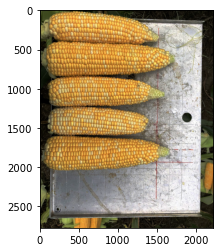

In [438]:
# let's look at an image

fileName = 'testing_IMG_8338.jpg'
image = imread(fileName)
image = exposure.equalize_hist(image) # equalizing the exposure
plt.imshow(image)

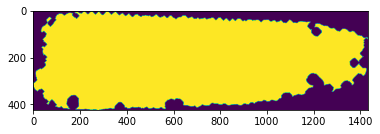

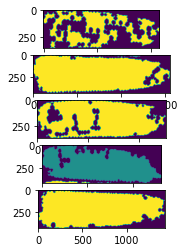

In [439]:
# run the segment_and_crop_loop function and then plot our five objects

top_five = segment_and_crop_loop(image)
fig, ax = plt.subplots(5,1)
ax[0].imshow(top_five[0])
ax[1].imshow(top_five[1])
ax[2].imshow(top_five[2])
ax[3].imshow(top_five[3])
ax[4].imshow(top_five[4])

In [112]:
# retrieve dimensions of the five objects using our earlier generated conversion factor, with the appropriate fileName provided

dimensions = []

for i in range(len(top_five)):
    first_dimension = top_five[i].shape[0] * conversion_dict[fileName]
    second_dimension = top_five[i].shape[1] * conversion_dict[fileName]
    both = [first_dimension,second_dimension]
    dimensions.append(both)
    
print('Ear 1:',dimensions[0])
print('Ear 2:',dimensions[1])
print('Ear 3:',dimensions[2])
print('Ear 4:',dimensions[3])
print('Ear 5:',dimensions[4])

Ear 1: [5.992274977806218, 22.16363524258716]
Ear 2: [6.38138374259883, 22.49048660501295]
Ear 3: [6.677106403841215, 23.14418932986454]
Ear 4: [6.552591599107579, 21.836783880161363]
Ear 5: [6.116789782539854, 23.42434764051522]


In [104]:
conversion_dict[fileName]

0.0172232856446723